In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'metrics_BIG_1/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['.ipynb_checkpoints', 'labels', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

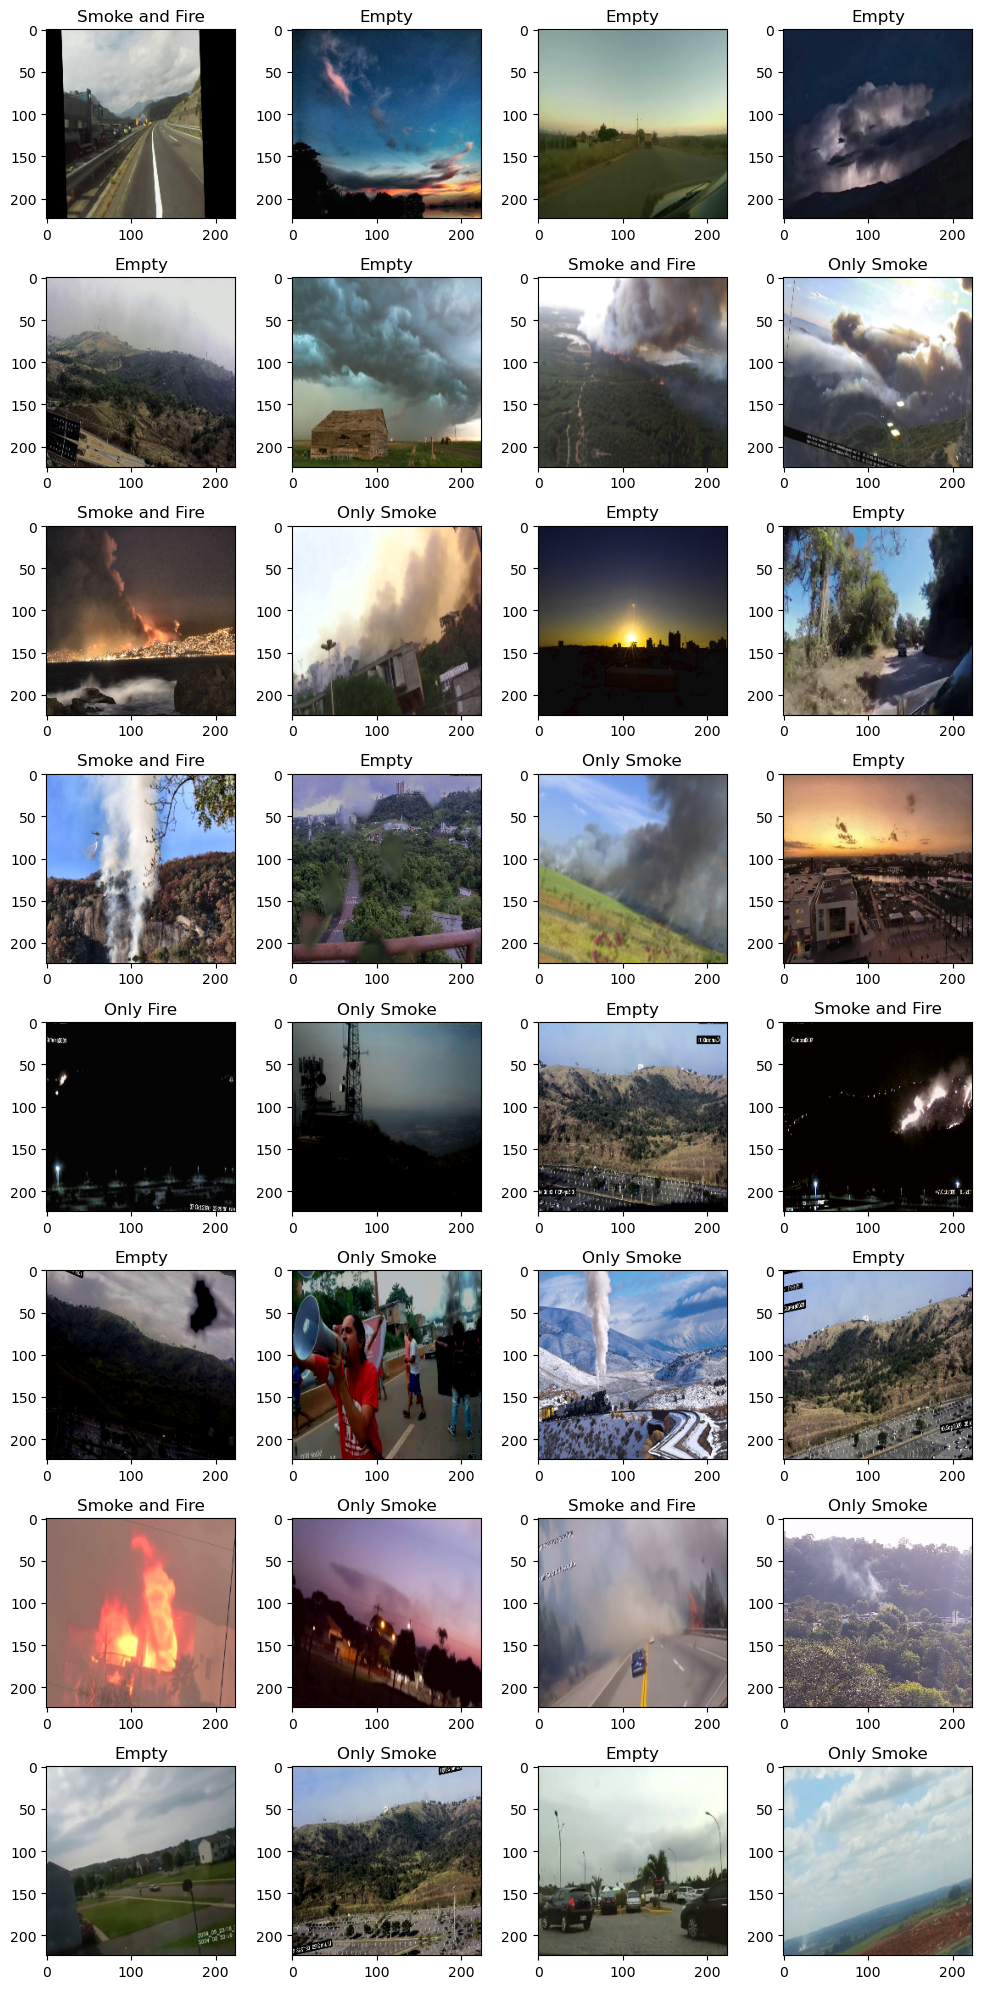

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: Optim Bed

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 128
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        ############## Recortar aquí. Quizá solo 1 Linear
        ############## Recortar en el backbone
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.last_channels, out_features=1),
            # nn.ReLU(),
            # nn.Linear(in_features=64, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.last_channels, out_features=1),
            # nn.ReLU(),
            # nn.Linear(in_features=64, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            #nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            ############## Quizá quitar este kernel
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Model: SqueezeNet Pretrained

In [11]:
class SqueezeNet_CLASSIFIER(nn.Module):
    def __init__(self, in_channels=3):
        super(SqueezeNet_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 512
        self.squeezenet = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', pretrained=True)
        self.model_wo_fc = nn.Sequential(*(list(self.squeezenet.children())[:-1]))
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=1),
            nn.ReLU()
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=1),
            nn.ReLU()
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        #print(f'Input: {x}')
        x = self.model_wo_fc(x)
        #print(f'X before avg pooling: {x}')
        x = self.pool(x)
        #print(f'X after avg pooling: {x}')
        x = torch.flatten(x, start_dim=1)
        #print(f'X before linnear:\n{x}')
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #print(f'X after linnear:\n{x}')
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [12]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = 2*smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': 2*self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [13]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [14]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [15]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [16]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Main Function

In [17]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if MODEL == "BED":
        print("Using BED Classifier")
        logger.info("Using BED Classifier")
        model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
    elif MODEL == "SQUEEZE":
        print("Using Squeeze Classifier")
        logger.info("Using Squeeze Classifier")
        model = SqueezeNet_CLASSIFIER().to(DEVICE)    
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")
    
    # Check model shape
    in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
    in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
    out_test = model(in_rand)
    print(f'Model shape is {out_test}')
    print(f'BED Model Arquitecture\n{model}')
    logger.info(f'Model shape is {out_test}')
    logger.info(f'BED Model Arquitecture\n{model}')
    
    
#     optimizer = optim.Adam(model.parameters(), 
#                            lr=LEARNING_RATE, 
#                            weight_decay=WEIGHT_DECAY)
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=LEARNING_RATE,
                                momentum=0.9, 
                                weight_decay=WEIGHT_DECAY, 
                                nesterov=True)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.8, 
                                                     patience=2, 
                                                     threshold=0.001, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-6)
    
    # MODEL PARAMETERS
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')
    logger.info(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(model.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    logger.info(f'Total parameters = {n_params}\n')
    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    train_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.4),
                A.HueSaturationValue(hue_shift_limit=10, p=0.2),
                A.Blur(blur_limit=(3,3), p=0.3),
                A.CLAHE(clip_limit=2.0, p=0.3),
                A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            ], p=0.9),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.Resize(IMG_H, IMG_W, p=1),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
            ToTensorV2(p=1),
        ]
    )
    
    # TRAIN DATASET
    print("\nTRAIN DFIRE dataset")
    logger.info("\nTRAIN DFIRE dataset")
    train_dataset = DFireDataset(img_h = IMG_H,
                                 img_w = IMG_W,
                                 img_dir = TRAIN_IMG_DIR,
                                 label_dir = TRAIN_LABEL_DIR,
                                 num_classes=N_CLASSES,
                                 ds_len = DS_LEN,
                                 transform=train_transform)

    print(f'Train dataset len: {len(train_dataset)}')
    logger.info(f'Train dataset len: {len(train_dataset)}')

    
    # VALIDATION DATASET
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
        ]
    )
    
    print("\nTEST DFire dataset")
    logger.info("\nTEST DFire dataset")
    val_dataset = DFireDataset(img_h = IMG_H,
                               img_w = IMG_W,
                               img_dir = VAL_IMG_DIR,
                               label_dir = VAL_LABEL_DIR,
                               num_classes = N_CLASSES,
                               ds_len = DS_LEN,
                               transform=val_transform)

    print(f'Test dataset len: {len(val_dataset)}')
    logger.info(f'Test dataset len: {len(val_dataset)}')
    
    
    # LOADERS
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY,
                            shuffle=False,
                            drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Pretrained Weights")
            logger.info("Pretrained Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main execute

In [18]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    main()

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Using BED Classifier
Model shape is tensor([[-0.2557, -0.1071],
        [-0.1942,  0.3633],
        [ 0.0080,  0.3202],
        [-0.1879,  0.1058]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

Training: 100%|██████████| 269/269 [02:05<00:00,  2.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
121.016     |87.426      |33.589      



Validating: 100%|██████████| 67/67 [00:19<00:00,  3.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
115.990     |88.792      |27.198      

SMOKE -> Precision: 0.498 - Recall: 0.987 - Accuracy: 0.515 - F1: 0.662
FIRE -> Precision: 0.661 - Recall: 0.646 - Accuracy: 0.823 - F1: 0.654

Saving model with new best validation loss: 115.990

=== EPOCH 1/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:05<00:00,  2.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
113.382     |85.691      |27.691      



Validating: 100%|██████████| 67/67 [00:19<00:00,  3.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
105.557     |83.086      |22.471      

SMOKE -> Precision: 0.621 - Recall: 0.587 - Accuracy: 0.629 - F1: 0.603
FIRE -> Precision: 0.705 - Recall: 0.661 - Accuracy: 0.841 - F1: 0.682

Saving model with new best validation loss: 105.557

=== EPOCH 2/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:02<00:00,  2.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
108.729     |83.575      |25.154      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
101.636     |80.792      |20.844      

SMOKE -> Precision: 0.628 - Recall: 0.617 - Accuracy: 0.640 - F1: 0.622
FIRE -> Precision: 0.751 - Recall: 0.633 - Accuracy: 0.851 - F1: 0.687

Saving model with new best validation loss: 101.636

=== EPOCH 3/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:03<00:00,  2.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
105.245     |81.623      |23.623      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
95.508      |76.719      |18.790      

SMOKE -> Precision: 0.659 - Recall: 0.654 - Accuracy: 0.671 - F1: 0.656
FIRE -> Precision: 0.743 - Recall: 0.749 - Accuracy: 0.868 - F1: 0.746

Saving model with new best validation loss: 95.508

=== EPOCH 4/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:59<00:00,  2.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
101.822     |79.586      |22.236      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
92.166      |74.815      |17.351      

SMOKE -> Precision: 0.727 - Recall: 0.548 - Accuracy: 0.684 - F1: 0.625
FIRE -> Precision: 0.787 - Recall: 0.759 - Accuracy: 0.885 - F1: 0.773

Saving model with new best validation loss: 92.166

=== EPOCH 5/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:00<00:00,  2.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
98.296      |77.467      |20.830      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
87.475      |71.118      |16.356      

SMOKE -> Precision: 0.728 - Recall: 0.667 - Accuracy: 0.720 - F1: 0.696
FIRE -> Precision: 0.782 - Recall: 0.796 - Accuracy: 0.890 - F1: 0.789

Saving model with new best validation loss: 87.475

=== EPOCH 6/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:03<00:00,  2.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
94.552      |74.880      |19.672      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
83.728      |68.142      |15.585      

SMOKE -> Precision: 0.727 - Recall: 0.733 - Accuracy: 0.740 - F1: 0.730
FIRE -> Precision: 0.842 - Recall: 0.811 - Accuracy: 0.912 - F1: 0.826

Saving model with new best validation loss: 83.728

=== EPOCH 7/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:02<00:00,  2.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
92.141      |73.259      |18.882      



Validating: 100%|██████████| 67/67 [00:19<00:00,  3.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
81.667      |66.723      |14.944      

SMOKE -> Precision: 0.711 - Recall: 0.785 - Accuracy: 0.743 - F1: 0.746
FIRE -> Precision: 0.803 - Recall: 0.860 - Accuracy: 0.909 - F1: 0.831

Saving model with new best validation loss: 81.667

=== EPOCH 8/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:02<00:00,  2.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
88.999      |70.969      |18.031      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
77.334      |63.394      |13.939      

SMOKE -> Precision: 0.723 - Recall: 0.813 - Accuracy: 0.760 - F1: 0.766
FIRE -> Precision: 0.829 - Recall: 0.851 - Accuracy: 0.916 - F1: 0.840

Saving model with new best validation loss: 77.334

=== EPOCH 9/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:04<00:00,  2.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
87.323      |69.718      |17.604      



Validating: 100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
76.779      |62.841      |13.938      

SMOKE -> Precision: 0.797 - Recall: 0.687 - Accuracy: 0.765 - F1: 0.738
FIRE -> Precision: 0.795 - Recall: 0.879 - Accuracy: 0.910 - F1: 0.835

Saving model with new best validation loss: 76.779

=== EPOCH 10/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:27<00:00,  1.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
83.917      |66.863      |17.054      



Validating: 100%|██████████| 67/67 [00:31<00:00,  2.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
72.055      |59.517      |12.538      

SMOKE -> Precision: 0.782 - Recall: 0.756 - Accuracy: 0.781 - F1: 0.769
FIRE -> Precision: 0.859 - Recall: 0.862 - Accuracy: 0.928 - F1: 0.861

Saving model with new best validation loss: 72.055

=== EPOCH 11/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:23<00:00,  1.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
82.350      |65.852      |16.498      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.743      |56.863      |12.880      

SMOKE -> Precision: 0.774 - Recall: 0.796 - Accuracy: 0.790 - F1: 0.785
FIRE -> Precision: 0.904 - Recall: 0.792 - Accuracy: 0.924 - F1: 0.844

Saving model with new best validation loss: 69.743

=== EPOCH 12/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
80.845      |64.727      |16.118      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.107      |55.686      |12.421      

SMOKE -> Precision: 0.830 - Recall: 0.760 - Accuracy: 0.809 - F1: 0.793
FIRE -> Precision: 0.908 - Recall: 0.817 - Accuracy: 0.931 - F1: 0.860

Saving model with new best validation loss: 68.107

=== EPOCH 13/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
78.748      |63.123      |15.625      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.039      |53.572      |11.468      

SMOKE -> Precision: 0.844 - Recall: 0.755 - Accuracy: 0.815 - F1: 0.797
FIRE -> Precision: 0.874 - Recall: 0.864 - Accuracy: 0.933 - F1: 0.869

Saving model with new best validation loss: 65.039

=== EPOCH 14/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
77.654      |62.414      |15.240      



Validating: 100%|██████████| 67/67 [00:24<00:00,  2.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.501      |52.904      |11.597      

SMOKE -> Precision: 0.813 - Recall: 0.800 - Accuracy: 0.815 - F1: 0.806
FIRE -> Precision: 0.862 - Recall: 0.867 - Accuracy: 0.930 - F1: 0.864

Saving model with new best validation loss: 64.501

=== EPOCH 15/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:13<00:00,  2.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
75.751      |60.773      |14.978      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.050      |50.573      |11.477      

SMOKE -> Precision: 0.811 - Recall: 0.829 - Accuracy: 0.825 - F1: 0.820
FIRE -> Precision: 0.851 - Recall: 0.886 - Accuracy: 0.931 - F1: 0.868

Saving model with new best validation loss: 62.050

=== EPOCH 16/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:12<00:00,  2.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.697      |59.846      |14.852      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.061      |52.161      |10.899      

SMOKE -> Precision: 0.871 - Recall: 0.717 - Accuracy: 0.813 - F1: 0.787
FIRE -> Precision: 0.917 - Recall: 0.821 - Accuracy: 0.934 - F1: 0.866

=== EPOCH 17/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:31<00:00,  1.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
73.903      |59.450      |14.454      



Validating: 100%|██████████| 67/67 [00:24<00:00,  2.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.377      |48.887      |11.490      

SMOKE -> Precision: 0.810 - Recall: 0.854 - Accuracy: 0.833 - F1: 0.832
FIRE -> Precision: 0.856 - Recall: 0.889 - Accuracy: 0.933 - F1: 0.872

Saving model with new best validation loss: 60.377

=== EPOCH 18/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:38<00:00,  1.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
71.941      |57.538      |14.402      



Validating: 100%|██████████| 67/67 [00:24<00:00,  2.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.815      |50.081      |10.734      

SMOKE -> Precision: 0.864 - Recall: 0.778 - Accuracy: 0.834 - F1: 0.818
FIRE -> Precision: 0.902 - Recall: 0.844 - Accuracy: 0.936 - F1: 0.872

=== EPOCH 19/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:25<00:00,  1.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
70.969      |57.230      |13.739      



Validating: 100%|██████████| 67/67 [00:27<00:00,  2.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.969      |48.218      |10.751      

SMOKE -> Precision: 0.860 - Recall: 0.801 - Accuracy: 0.842 - F1: 0.830
FIRE -> Precision: 0.930 - Recall: 0.820 - Accuracy: 0.937 - F1: 0.871

Saving model with new best validation loss: 58.969

=== EPOCH 20/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:23<00:00,  1.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
70.478      |56.481      |13.997      



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.447      |45.065      |10.383      

SMOKE -> Precision: 0.860 - Recall: 0.849 - Accuracy: 0.861 - F1: 0.854
FIRE -> Precision: 0.891 - Recall: 0.862 - Accuracy: 0.937 - F1: 0.876

Saving model with new best validation loss: 55.447

=== EPOCH 21/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:11<00:00,  2.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.644      |54.786      |13.858      



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.253      |43.622      |10.631      

SMOKE -> Precision: 0.860 - Recall: 0.846 - Accuracy: 0.860 - F1: 0.853
FIRE -> Precision: 0.929 - Recall: 0.818 - Accuracy: 0.937 - F1: 0.870

Saving model with new best validation loss: 54.253

=== EPOCH 22/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:21<00:00,  1.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.830      |55.010      |13.820      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.131      |44.042      |10.089      

SMOKE -> Precision: 0.827 - Recall: 0.883 - Accuracy: 0.855 - F1: 0.854
FIRE -> Precision: 0.885 - Recall: 0.876 - Accuracy: 0.938 - F1: 0.880

Saving model with new best validation loss: 54.131

=== EPOCH 23/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:20<00:00,  1.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.085      |54.064      |13.021      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.687      |43.196      |10.491      

SMOKE -> Precision: 0.889 - Recall: 0.821 - Accuracy: 0.865 - F1: 0.854
FIRE -> Precision: 0.941 - Recall: 0.816 - Accuracy: 0.939 - F1: 0.874

Saving model with new best validation loss: 53.687

=== EPOCH 24/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.300      |53.053      |13.247      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.738      |42.574      |10.164      

SMOKE -> Precision: 0.910 - Recall: 0.784 - Accuracy: 0.859 - F1: 0.842
FIRE -> Precision: 0.891 - Recall: 0.872 - Accuracy: 0.939 - F1: 0.882

Saving model with new best validation loss: 52.738

=== EPOCH 25/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:10<00:00,  2.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.380      |52.298      |13.083      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.256      |42.013      |10.243      

SMOKE -> Precision: 0.870 - Recall: 0.855 - Accuracy: 0.869 - F1: 0.863
FIRE -> Precision: 0.934 - Recall: 0.832 - Accuracy: 0.941 - F1: 0.880

Saving model with new best validation loss: 52.256

=== EPOCH 26/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.523      |51.403      |13.120      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.518      |44.992      |9.525       

SMOKE -> Precision: 0.915 - Recall: 0.760 - Accuracy: 0.851 - F1: 0.830
FIRE -> Precision: 0.886 - Recall: 0.887 - Accuracy: 0.941 - F1: 0.887

=== EPOCH 27/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.207      |50.530      |12.676      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.769      |39.774      |9.995       

SMOKE -> Precision: 0.861 - Recall: 0.873 - Accuracy: 0.871 - F1: 0.867
FIRE -> Precision: 0.927 - Recall: 0.850 - Accuracy: 0.944 - F1: 0.887

Saving model with new best validation loss: 49.769

=== EPOCH 28/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.667      |50.108      |12.559      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.183      |40.386      |9.798       

SMOKE -> Precision: 0.851 - Recall: 0.886 - Accuracy: 0.871 - F1: 0.868
FIRE -> Precision: 0.914 - Recall: 0.858 - Accuracy: 0.942 - F1: 0.885

=== EPOCH 29/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.881      |50.251      |12.631      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.954      |40.026      |9.927       

SMOKE -> Precision: 0.876 - Recall: 0.861 - Accuracy: 0.875 - F1: 0.869
FIRE -> Precision: 0.923 - Recall: 0.859 - Accuracy: 0.945 - F1: 0.890

=== EPOCH 30/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:28<00:00,  1.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.029      |49.015      |12.014      



Validating: 100%|██████████| 67/67 [00:32<00:00,  2.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.195      |38.872      |9.323       

SMOKE -> Precision: 0.900 - Recall: 0.838 - Accuracy: 0.877 - F1: 0.868
FIRE -> Precision: 0.893 - Recall: 0.895 - Accuracy: 0.945 - F1: 0.894

Saving model with new best validation loss: 48.195

=== EPOCH 31/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:35<00:00,  1.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.816      |48.476      |12.340      



Validating: 100%|██████████| 67/67 [00:25<00:00,  2.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.468      |37.738      |9.729       

SMOKE -> Precision: 0.866 - Recall: 0.887 - Accuracy: 0.879 - F1: 0.876
FIRE -> Precision: 0.899 - Recall: 0.875 - Accuracy: 0.942 - F1: 0.887

Saving model with new best validation loss: 47.468

=== EPOCH 32/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.521      |48.316      |12.205      



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.523      |40.270      |9.252       

SMOKE -> Precision: 0.916 - Recall: 0.810 - Accuracy: 0.873 - F1: 0.860
FIRE -> Precision: 0.932 - Recall: 0.860 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 33/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.439      |47.361      |12.078      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.184      |37.657      |9.527       

SMOKE -> Precision: 0.873 - Recall: 0.880 - Accuracy: 0.881 - F1: 0.877
FIRE -> Precision: 0.910 - Recall: 0.879 - Accuracy: 0.946 - F1: 0.895

Saving model with new best validation loss: 47.184

=== EPOCH 34/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:18<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.279      |46.466      |11.813      



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.914      |38.321      |9.593       

SMOKE -> Precision: 0.864 - Recall: 0.896 - Accuracy: 0.882 - F1: 0.880
FIRE -> Precision: 0.900 - Recall: 0.895 - Accuracy: 0.947 - F1: 0.898

=== EPOCH 35/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:32<00:00,  1.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.243      |47.382      |11.861      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.193      |38.012      |9.181       

SMOKE -> Precision: 0.838 - Recall: 0.924 - Accuracy: 0.877 - F1: 0.879
FIRE -> Precision: 0.905 - Recall: 0.888 - Accuracy: 0.947 - F1: 0.896

=== EPOCH 36/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.264      |46.620      |11.644      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.979      |36.685      |9.294       

SMOKE -> Precision: 0.896 - Recall: 0.860 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.897 - Recall: 0.899 - Accuracy: 0.947 - F1: 0.898

Saving model with new best validation loss: 45.979

=== EPOCH 37/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:18<00:00,  1.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.380      |44.649      |11.731      



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.057      |37.202      |8.855       

SMOKE -> Precision: 0.840 - Recall: 0.936 - Accuracy: 0.883 - F1: 0.885
FIRE -> Precision: 0.921 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 38/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.718      |44.520      |11.198      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.234      |36.097      |9.137       

SMOKE -> Precision: 0.846 - Recall: 0.935 - Accuracy: 0.887 - F1: 0.889
FIRE -> Precision: 0.921 - Recall: 0.877 - Accuracy: 0.948 - F1: 0.898

Saving model with new best validation loss: 45.234

=== EPOCH 39/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.837      |44.690      |11.147      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.842      |34.289      |9.554       

SMOKE -> Precision: 0.873 - Recall: 0.909 - Accuracy: 0.893 - F1: 0.891
FIRE -> Precision: 0.928 - Recall: 0.845 - Accuracy: 0.943 - F1: 0.884

Saving model with new best validation loss: 43.842

=== EPOCH 40/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:24<00:00,  1.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.179      |43.985      |11.194      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.222      |40.402      |9.820       

SMOKE -> Precision: 0.931 - Recall: 0.782 - Accuracy: 0.867 - F1: 0.850
FIRE -> Precision: 0.942 - Recall: 0.843 - Accuracy: 0.946 - F1: 0.890

=== EPOCH 41/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.659      |43.340      |11.319      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.193      |36.953      |9.240       

SMOKE -> Precision: 0.917 - Recall: 0.836 - Accuracy: 0.885 - F1: 0.874
FIRE -> Precision: 0.923 - Recall: 0.866 - Accuracy: 0.947 - F1: 0.894

=== EPOCH 42/99 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [02:33<00:00,  1.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.088      |42.921      |11.167      



Validating: 100%|██████████| 67/67 [00:24<00:00,  2.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.843      |40.191      |8.652       

SMOKE -> Precision: 0.930 - Recall: 0.791 - Accuracy: 0.871 - F1: 0.855
FIRE -> Precision: 0.910 - Recall: 0.896 - Accuracy: 0.950 - F1: 0.903

=== EPOCH 43/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:41<00:00,  1.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.878      |41.934      |10.944      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.442      |33.409      |9.033       

SMOKE -> Precision: 0.862 - Recall: 0.933 - Accuracy: 0.896 - F1: 0.896
FIRE -> Precision: 0.892 - Recall: 0.904 - Accuracy: 0.947 - F1: 0.898

Saving model with new best validation loss: 42.442

=== EPOCH 44/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.002      |41.315      |10.687      



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.279      |32.904      |8.375       

SMOKE -> Precision: 0.906 - Recall: 0.879 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.914 - Recall: 0.885 - Accuracy: 0.949 - F1: 0.899

Saving model with new best validation loss: 41.279

=== EPOCH 45/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:26<00:00,  1.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.281      |40.514      |10.767      



Validating: 100%|██████████| 67/67 [00:28<00:00,  2.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.080      |32.098      |8.983       

SMOKE -> Precision: 0.903 - Recall: 0.879 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.936 - Recall: 0.855 - Accuracy: 0.947 - F1: 0.894

Saving model with new best validation loss: 41.080

=== EPOCH 46/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:35<00:00,  1.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.780      |40.451      |10.329      



Validating: 100%|██████████| 67/67 [00:24<00:00,  2.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.952      |37.253      |8.699       

SMOKE -> Precision: 0.914 - Recall: 0.834 - Accuracy: 0.882 - F1: 0.872
FIRE -> Precision: 0.924 - Recall: 0.886 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 47/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:23<00:00,  1.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.645      |40.100      |10.545      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.400      |33.720      |8.680       

SMOKE -> Precision: 0.926 - Recall: 0.850 - Accuracy: 0.895 - F1: 0.887
FIRE -> Precision: 0.927 - Recall: 0.878 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 48/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:20<00:00,  1.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.562      |39.249      |10.313      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.680      |31.234      |8.446       

SMOKE -> Precision: 0.895 - Recall: 0.905 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.920 - Recall: 0.886 - Accuracy: 0.951 - F1: 0.903

Saving model with new best validation loss: 39.680

=== EPOCH 49/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:10<00:00,  2.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.390      |39.065      |10.325      



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.429      |32.247      |8.182       

SMOKE -> Precision: 0.911 - Recall: 0.876 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.916 - Recall: 0.894 - Accuracy: 0.951 - F1: 0.905

=== EPOCH 50/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.139      |39.146      |9.993       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.262      |30.888      |8.374       

SMOKE -> Precision: 0.916 - Recall: 0.878 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.922 - Recall: 0.879 - Accuracy: 0.949 - F1: 0.900

Saving model with new best validation loss: 39.262

=== EPOCH 51/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:19<00:00,  1.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.915      |38.802      |10.113      



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.466      |31.127      |8.339       

SMOKE -> Precision: 0.894 - Recall: 0.904 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.923 - Recall: 0.882 - Accuracy: 0.950 - F1: 0.902

=== EPOCH 52/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:11<00:00,  2.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.404      |38.406      |9.998       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.653      |29.294      |8.359       

SMOKE -> Precision: 0.910 - Recall: 0.906 - Accuracy: 0.912 - F1: 0.908
FIRE -> Precision: 0.895 - Recall: 0.905 - Accuracy: 0.948 - F1: 0.900

Saving model with new best validation loss: 37.653

=== EPOCH 53/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:27<00:00,  1.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.430      |38.441      |9.989       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.764      |31.922      |8.841       

SMOKE -> Precision: 0.928 - Recall: 0.866 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.948 - Recall: 0.852 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 54/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.570      |37.430      |10.140      



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.657      |33.300      |8.358       

SMOKE -> Precision: 0.921 - Recall: 0.861 - Accuracy: 0.897 - F1: 0.890
FIRE -> Precision: 0.937 - Recall: 0.869 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 55/99 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [02:17<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.779      |37.886      |9.893       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.046      |36.315      |8.731       

SMOKE -> Precision: 0.831 - Recall: 0.962 - Accuracy: 0.888 - F1: 0.892
FIRE -> Precision: 0.946 - Recall: 0.860 - Accuracy: 0.951 - F1: 0.901

=== EPOCH 56/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:35<00:00,  1.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.201      |37.492      |9.709       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.154      |31.306      |7.848       

SMOKE -> Precision: 0.917 - Recall: 0.874 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.920 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 57/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.068      |36.451      |9.617       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.705      |30.587      |8.118       

SMOKE -> Precision: 0.901 - Recall: 0.904 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.907 - Recall: 0.905 - Accuracy: 0.951 - F1: 0.906

=== EPOCH 58/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:13<00:00,  2.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.026      |35.440      |9.586       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.562      |28.458      |8.104       

SMOKE -> Precision: 0.901 - Recall: 0.925 - Accuracy: 0.915 - F1: 0.913
FIRE -> Precision: 0.908 - Recall: 0.892 - Accuracy: 0.949 - F1: 0.900

Saving model with new best validation loss: 36.562

=== EPOCH 59/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:11<00:00,  2.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.258      |34.674      |9.584       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.788      |30.396      |8.392       

SMOKE -> Precision: 0.930 - Recall: 0.868 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.953 - Recall: 0.865 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 60/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:19<00:00,  1.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.103      |35.439      |9.664       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.003      |28.988      |8.015       

SMOKE -> Precision: 0.904 - Recall: 0.918 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.915 - Recall: 0.915 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 61/99 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [02:18<00:00,  1.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.436      |34.793      |9.643       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.854      |30.844      |8.010       

SMOKE -> Precision: 0.877 - Recall: 0.948 - Accuracy: 0.911 - F1: 0.911
FIRE -> Precision: 0.906 - Recall: 0.910 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 62/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:14<00:00,  1.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.297      |34.049      |9.248       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.873      |29.023      |7.850       

SMOKE -> Precision: 0.930 - Recall: 0.883 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.922 - Recall: 0.899 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 63/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.023      |32.986      |9.036       



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.063      |28.157      |7.906       

SMOKE -> Precision: 0.916 - Recall: 0.905 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 36.063

=== EPOCH 64/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:21<00:00,  1.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.026      |33.850      |9.176       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.691      |28.696      |7.995       

SMOKE -> Precision: 0.875 - Recall: 0.956 - Accuracy: 0.913 - F1: 0.914
FIRE -> Precision: 0.920 - Recall: 0.893 - Accuracy: 0.952 - F1: 0.906

=== EPOCH 65/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:28<00:00,  1.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.693      |33.580      |9.113       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.312      |29.143      |8.169       

SMOKE -> Precision: 0.915 - Recall: 0.894 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.939 - Recall: 0.872 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 66/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.708      |33.492      |9.216       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.252      |27.025      |8.227       

SMOKE -> Precision: 0.909 - Recall: 0.928 - Accuracy: 0.921 - F1: 0.919
FIRE -> Precision: 0.929 - Recall: 0.866 - Accuracy: 0.948 - F1: 0.896

Saving model with new best validation loss: 35.252

=== EPOCH 67/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:20<00:00,  1.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.870      |31.896      |8.974       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.354      |29.382      |7.972       

SMOKE -> Precision: 0.923 - Recall: 0.892 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.933 - Recall: 0.887 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 68/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.527      |32.576      |8.951       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.590      |27.755      |7.834       

SMOKE -> Precision: 0.902 - Recall: 0.937 - Accuracy: 0.921 - F1: 0.919
FIRE -> Precision: 0.920 - Recall: 0.899 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 69/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [02:31<00:00,  1.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.844      |31.764      |9.080       



Validating: 100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.826      |27.804      |8.022       

SMOKE -> Precision: 0.923 - Recall: 0.908 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.927 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 70/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:43<00:00,  1.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.024      |31.094      |8.931       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.427      |27.808      |7.618       

SMOKE -> Precision: 0.917 - Recall: 0.911 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.925 - Recall: 0.903 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 71/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:40<00:00,  1.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.069      |31.297      |8.772       



Validating: 100%|██████████| 67/67 [00:29<00:00,  2.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.762      |28.760      |8.001       

SMOKE -> Precision: 0.884 - Recall: 0.957 - Accuracy: 0.919 - F1: 0.919
FIRE -> Precision: 0.900 - Recall: 0.922 - Accuracy: 0.953 - F1: 0.911

=== EPOCH 72/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:36<00:00,  1.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.763      |31.396      |8.367       



Validating: 100%|██████████| 67/67 [00:31<00:00,  2.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.555      |26.575      |7.980       

SMOKE -> Precision: 0.920 - Recall: 0.919 - Accuracy: 0.923 - F1: 0.919
FIRE -> Precision: 0.939 - Recall: 0.884 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 34.555

=== EPOCH 73/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:22<00:00,  1.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.032      |31.285      |8.747       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.066      |28.093      |7.973       

SMOKE -> Precision: 0.921 - Recall: 0.918 - Accuracy: 0.923 - F1: 0.919
FIRE -> Precision: 0.919 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 74/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.135      |31.396      |8.739       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.614      |26.645      |7.969       

SMOKE -> Precision: 0.916 - Recall: 0.920 - Accuracy: 0.921 - F1: 0.918
FIRE -> Precision: 0.910 - Recall: 0.916 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 75/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:19<00:00,  1.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.822      |31.243      |8.579       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.538      |26.562      |7.976       

SMOKE -> Precision: 0.903 - Recall: 0.941 - Accuracy: 0.923 - F1: 0.922
FIRE -> Precision: 0.915 - Recall: 0.902 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 34.538

=== EPOCH 76/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.651      |31.270      |8.381       



Validating: 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.098      |27.189      |7.909       

SMOKE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.936 - Recall: 0.871 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 77/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.080      |30.669      |8.410       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.099      |28.088      |8.011       

SMOKE -> Precision: 0.882 - Recall: 0.953 - Accuracy: 0.916 - F1: 0.916
FIRE -> Precision: 0.938 - Recall: 0.878 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 78/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [02:17<00:00,  1.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.340      |29.830      |8.510       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.713      |27.053      |7.660       

SMOKE -> Precision: 0.907 - Recall: 0.934 - Accuracy: 0.922 - F1: 0.920
FIRE -> Precision: 0.920 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 79/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.568      |30.173      |8.395       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.000      |27.473      |7.528       

SMOKE -> Precision: 0.931 - Recall: 0.899 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.922 - Recall: 0.900 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 80/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [02:22<00:00,  1.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.404      |29.165      |8.239       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.397      |26.518      |7.878       

SMOKE -> Precision: 0.901 - Recall: 0.939 - Accuracy: 0.921 - F1: 0.920
FIRE -> Precision: 0.927 - Recall: 0.887 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 34.397

=== EPOCH 81/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [02:21<00:00,  1.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.076      |29.587      |8.489       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.112      |27.380      |7.732       

SMOKE -> Precision: 0.911 - Recall: 0.928 - Accuracy: 0.922 - F1: 0.920
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 82/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [02:21<00:00,  1.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.587      |29.390      |8.197       



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.135      |27.584      |7.551       

SMOKE -> Precision: 0.901 - Recall: 0.938 - Accuracy: 0.920 - F1: 0.919
FIRE -> Precision: 0.926 - Recall: 0.891 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 83/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [02:19<00:00,  1.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.442      |29.133      |8.309       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.312      |27.624      |7.688       

SMOKE -> Precision: 0.891 - Recall: 0.948 - Accuracy: 0.919 - F1: 0.919
FIRE -> Precision: 0.914 - Recall: 0.898 - Accuracy: 0.952 - F1: 0.906

=== EPOCH 84/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.275      |29.003      |8.272       



Validating: 100%|██████████| 67/67 [00:22<00:00,  2.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.980      |26.432      |7.548       

SMOKE -> Precision: 0.898 - Recall: 0.942 - Accuracy: 0.921 - F1: 0.920
FIRE -> Precision: 0.933 - Recall: 0.889 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 33.980

=== EPOCH 85/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.962      |27.795      |8.168       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.258      |26.575      |7.682       

SMOKE -> Precision: 0.915 - Recall: 0.925 - Accuracy: 0.923 - F1: 0.920
FIRE -> Precision: 0.935 - Recall: 0.877 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 86/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [02:10<00:00,  2.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.727      |28.284      |8.442       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.958      |26.915      |8.043       

SMOKE -> Precision: 0.909 - Recall: 0.934 - Accuracy: 0.923 - F1: 0.921
FIRE -> Precision: 0.942 - Recall: 0.869 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 87/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.176      |28.234      |7.943       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.169      |28.535      |7.634       

SMOKE -> Precision: 0.931 - Recall: 0.893 - Accuracy: 0.917 - F1: 0.911
FIRE -> Precision: 0.919 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 88/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [02:20<00:00,  1.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.394      |28.223      |8.171       



Validating: 100%|██████████| 67/67 [00:23<00:00,  2.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.835      |27.108      |7.728       

SMOKE -> Precision: 0.897 - Recall: 0.949 - Accuracy: 0.923 - F1: 0.922
FIRE -> Precision: 0.932 - Recall: 0.879 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 89/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [02:19<00:00,  1.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.223      |28.121      |8.102       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.476      |25.883      |7.593       

SMOKE -> Precision: 0.911 - Recall: 0.941 - Accuracy: 0.927 - F1: 0.926
FIRE -> Precision: 0.925 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 33.476

=== EPOCH 90/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [02:09<00:00,  2.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.061      |26.970      |8.090       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.193      |26.380      |7.814       

SMOKE -> Precision: 0.907 - Recall: 0.943 - Accuracy: 0.926 - F1: 0.925
FIRE -> Precision: 0.929 - Recall: 0.889 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 91/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [02:08<00:00,  2.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.727      |27.745      |7.982       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.498      |25.908      |7.590       

SMOKE -> Precision: 0.907 - Recall: 0.941 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.930 - Recall: 0.887 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 92/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [02:17<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.995      |27.016      |7.979       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.866      |28.184      |7.682       

SMOKE -> Precision: 0.888 - Recall: 0.955 - Accuracy: 0.921 - F1: 0.921
FIRE -> Precision: 0.910 - Recall: 0.915 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 93/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|██████████| 269/269 [02:18<00:00,  1.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.870      |26.999      |7.871       



Validating: 100%|██████████| 67/67 [00:19<00:00,  3.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.249      |25.654      |7.595       

SMOKE -> Precision: 0.925 - Recall: 0.923 - Accuracy: 0.927 - F1: 0.924
FIRE -> Precision: 0.925 - Recall: 0.893 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 33.249

=== EPOCH 94/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|██████████| 269/269 [02:18<00:00,  1.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.027      |27.002      |8.025       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.311      |25.768      |7.543       

SMOKE -> Precision: 0.903 - Recall: 0.944 - Accuracy: 0.924 - F1: 0.923
FIRE -> Precision: 0.925 - Recall: 0.898 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 95/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|██████████| 269/269 [02:14<00:00,  2.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.681      |26.587      |8.094       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.604      |25.801      |7.802       

SMOKE -> Precision: 0.909 - Recall: 0.937 - Accuracy: 0.924 - F1: 0.922
FIRE -> Precision: 0.936 - Recall: 0.878 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 96/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|██████████| 269/269 [02:16<00:00,  1.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.625      |26.528      |8.096       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.469      |25.917      |7.552       

SMOKE -> Precision: 0.906 - Recall: 0.944 - Accuracy: 0.926 - F1: 0.925
FIRE -> Precision: 0.917 - Recall: 0.908 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 97/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|██████████| 269/269 [02:18<00:00,  1.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.798      |26.205      |7.593       



Validating: 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.918      |25.316      |7.602       

SMOKE -> Precision: 0.925 - Recall: 0.921 - Accuracy: 0.926 - F1: 0.923
FIRE -> Precision: 0.929 - Recall: 0.891 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 32.918

=== EPOCH 98/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|██████████| 269/269 [02:13<00:00,  2.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.380      |26.563      |7.818       



Validating: 100%|██████████| 67/67 [00:21<00:00,  3.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.147      |25.609      |7.538       

SMOKE -> Precision: 0.917 - Recall: 0.921 - Accuracy: 0.922 - F1: 0.919
FIRE -> Precision: 0.921 - Recall: 0.903 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 99/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|██████████| 269/269 [02:16<00:00,  1.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.909      |26.034      |7.874       



Validating: 100%|██████████| 67/67 [00:20<00:00,  3.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.577      |25.987      |7.589       

SMOKE -> Precision: 0.910 - Recall: 0.938 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.920 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

***Script finished: 20:23:54

Time elapsed: 4:30:00.984887


In [19]:
# val_transform = A.Compose([
#     A.Resize(IMG_H, IMG_W, p=1),
#     #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
#     ToTensorV2(p=1),
#     ]
# )

# val_dataset = DFireDataset(img_h = IMG_H,
#                            img_w = IMG_W,
#                            img_dir = VAL_IMG_DIR,
#                            label_dir = VAL_LABEL_DIR,
#                            num_classes = N_CLASSES,
#                            ds_len=512,
#                            transform=val_transform)

# # LOADER
# plot_loader = DataLoader(dataset=val_dataset,
#                          batch_size=BATCH_SIZE,
#                          num_workers=NUM_WORKERS,
#                          pin_memory=PIN_MEMORY,
#                          shuffle=True,
#                          drop_last=True)



In [20]:
# view_model = BED_CLASSIFIER(num_classes=N_CLASSES)
# model_file = log_path + 'bed_classifier_5epoch.pt'

# print(model_file)

# checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
# view_model.load_state_dict(checkpoint['model_state_dict'])

# view_model.eval() 

In [21]:
# import matplotlib.patches as patches 

In [22]:
# for i, (img, label) in enumerate(plot_loader):

#     fig, ax = plt.subplots(1,4, figsize=(10, 20))
#     print(ax.shape)
#     for idx in range(4):
#             plt.subplot(1, 4, idx+1)
#             plt.imshow(img[idx].permute(1, 2, 0))

#             label_txt = ""
#             print(f'Label: {label[idx]}')
#             if label[idx, 0] == 1 and label[idx, 1] == 1:
#                 label_txt += "Smoke and Fire"
#             elif label[idx, 0] == 1 and label[idx, 1] == 0:
#                 label_txt += "Only Smoke"
#             elif label[idx, 0] == 0 and label[idx, 1] == 1:
#                 label_txt += "Only Fire"
#             else:
#                 label_txt += "Empty"

#             pred = torch.sigmoid( view_model(img[idx].unsqueeze(dim=0) / 255.) )
#             print(f'Pred: {pred}')
#             pred_txt = ""
#             if pred[..., 0] > 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Smoke and Fire"
#             elif pred[..., 0] > 0.5 and pred[..., 1] < 0.5:
#                 pred_txt += "Only Smoke"
#             elif pred[..., 0] < 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Only Fire"
#             else:
#                 pred_txt += "Empty"

#             if pred_txt == label_txt:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_W-3, linewidth=3, edgecolor='g', facecolor="none")
#             else:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_H-3, linewidth=3, edgecolor='r', facecolor="none")
                
#             ax[idx].add_patch(rect)
            
#             title = "Label: " + label_txt + " | Pred: " + pred_txt
#             plt.title(title, fontsize=8)

#             if (idx == 4):
#                 break
#     plt.tight_layout()
#     plt.show()
#     break

# Plot Results

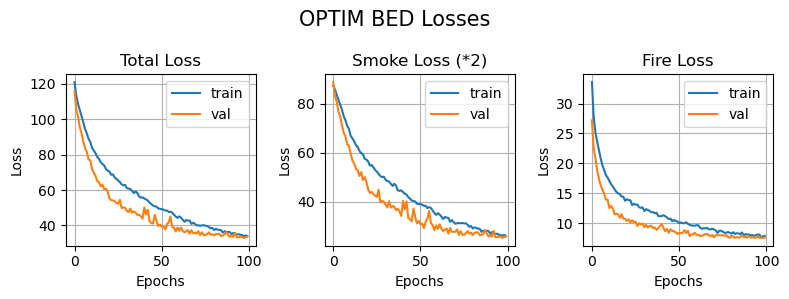

In [23]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss (*2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()